In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

import torch.nn as nn
from torchvision.models import vgg11_bn

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

### path list 구성

In [2]:
train_path = 'data/train/'
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
train_list = []
for c in classes:
    c_list = os.listdir(f'{train_path}{c}')
    for name in c_list:
        train_list.append(f'{train_path}{c}/{name}')

test_path = 'data/test/0/'
f_list = os.listdir(test_path)
test_list = []
for name in f_list:
    test_list.append(f'{test_path}{name}')

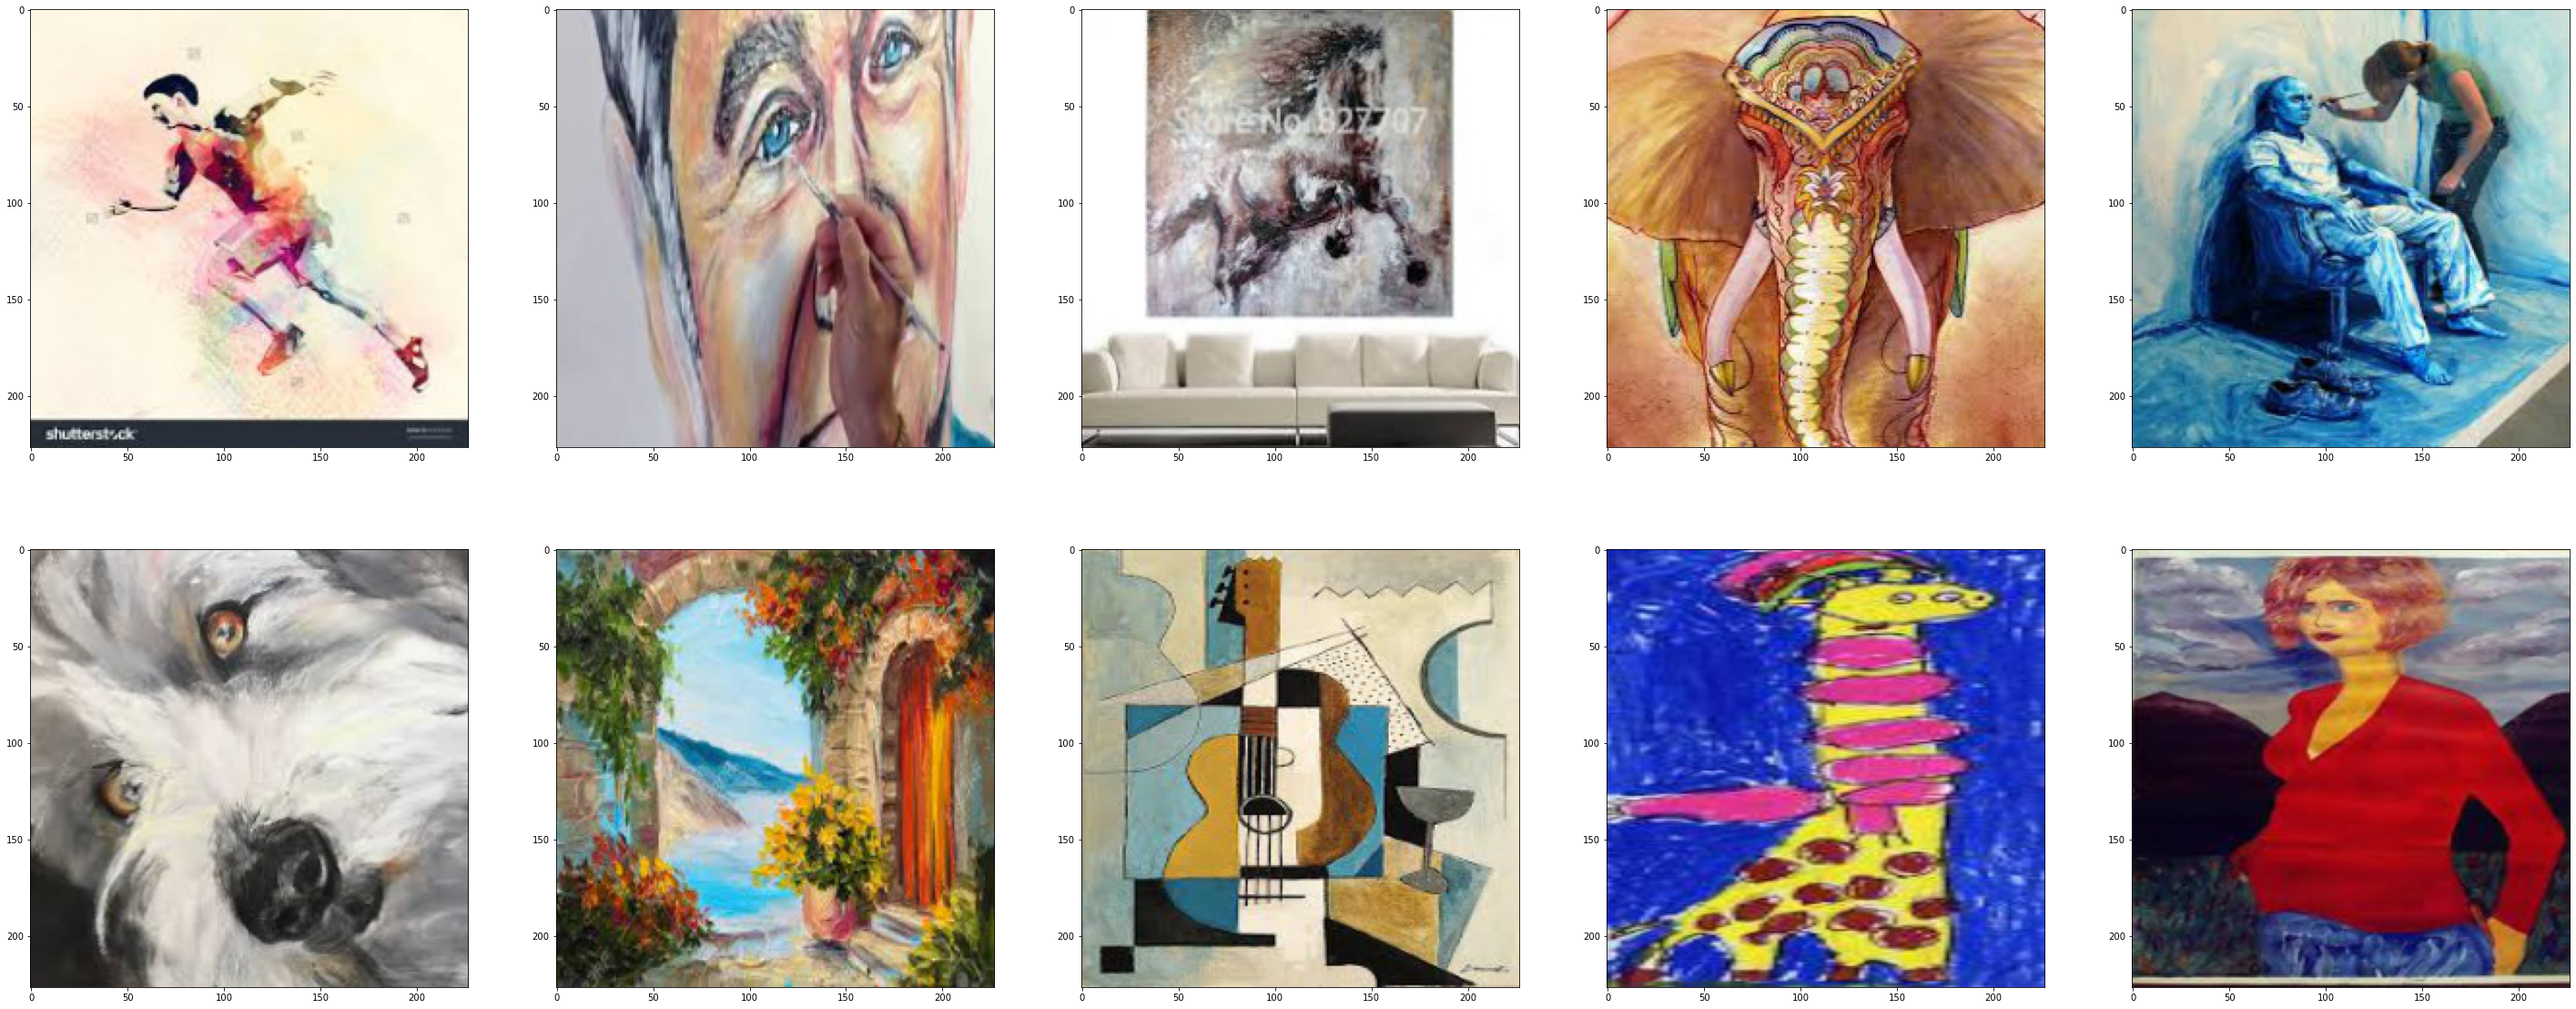

In [3]:
plt.figure(figsize=(50, 20))
for i in range(10):
    j = np.random.randint(len(train_list))
    img = Image.open(train_list[j]).convert('RGB')
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
plt.show()

### dataset 구성

In [4]:
class Customdataset(Dataset):
    def __init__(self, file_list, transform=None, train=True):
        self.file_list = file_list
        self.transform = transform
        self.train = train
        self.class_encoder = {
            'dog' : 0,
            'elephant' : 1,
            'giraffe' : 2,
            'guitar' : 3,
            'horse' : 4,
            'house' : 5,
            'person' : 6,
            }
        if train:
            self.targets = [self.class_encoder[path.split('/')[2]] for path in file_list]
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)

        if self.train:
            target = self.targets[index]
            target = torch.tensor(target, dtype=torch.int64)
            return img, target
        else:
            return img

In [5]:
class Subset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        img, target = self.dataset[self.indices[index]]
        
        if self.transform:
            img = self.transform(img)

        return img, target

In [6]:
def get_augmentation(train=True):
    if train:
        transforms = T.Compose([
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                T.RandomHorizontalFlip(p=0.5),
                ])
    else:
        transforms = T.Compose([
                T.Resize((32, 32)),
                T.ToTensor(),
                T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ])
    return transforms

### train/val split, dataloader 구성

In [7]:
batch_size = 32

In [8]:
trainval_ds = Customdataset(train_list, transform=None, train=True)
train_idx, val_idx = train_test_split(np.arange(len(trainval_ds)), test_size=0.2, stratify=trainval_ds.targets)
train_ds = Subset(trainval_ds, train_idx, transform=get_augmentation(train=True))
val_ds = Subset(trainval_ds, val_idx, transform=get_augmentation(train=False))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

### 모델 구성

In [9]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = vgg11_bn(pretrained=True).features
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(512, 7)

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x).squeeze(3).squeeze(2)
        x = self.classifier(x)

        return x

### 학습

In [10]:
lr = 1e-3
weight_decay = 1e-6
epochs = 200
early_stopping_patience = 10
num_try = 'mixup'
model_path = f'model/{num_try}_best.pt'

mixup = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
def train(model, train_loader, optimizer, mixup=False):
    model.train()

    targets = []
    preds = []
    total_loss = 0
    for i, (img, target) in enumerate(train_loader):
        img, target = img.to(device), target.to(device) 

        if mixup:
            lamb = np.random.beta(1, 1)
            mixup_idx = torch.randperm(img.shape[0], device=device) # batch_size = 32
            img_b, target_b = img[mixup_idx], target[mixup_idx]
            mixup_img = lamb * img + (1-lamb) * img_b
            out = model(mixup_img)
            loss = lamb * F.cross_entropy(out, target) + (1-lamb) * F.cross_entropy(out, target_b)
        else:
            out = model(img)
            loss = F.cross_entropy(out, target)

        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = out.detach().numpy()
        preds.append(pred)

        target = target.detach().numpy()
        targets.append(target)

    preds = np.argmax(np.vstack(preds), 1)
    targets = np.hstack(targets)
    
    return total_loss/(i+1), accuracy_score(targets, preds)

In [12]:
def val(model, val_loader):
    model.eval()

    targets = []
    preds = []
    total_loss = 0
    with torch.no_grad():
        for i, (img, target) in enumerate(val_loader):
            img, target = img.to(device), target.to(device)
            out = model(img)

            loss = F.cross_entropy(out, target)
            total_loss += loss.item()

            pred = out.detach().numpy()
            preds.append(pred)

            target = target.detach().numpy()
            targets.append(target)

        preds = np.argmax(np.vstack(preds), 1)
        targets = np.hstack(targets)
    
    return total_loss/(i+1), accuracy_score(targets, preds)

In [13]:
model = Classifier().to(device)

optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6, verbose=True)

train_losses, train_accs = np.zeros(epochs), np.zeros(epochs)
val_losses, val_accs = np.zeros(epochs), np.zeros(epochs)

for e in range(epochs):
    time_0 = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, mixup)
    val_loss, val_acc = val(model, val_loader)

    scheduler.step(-val_acc)

    time_e = time.time()
    print(f'Epoch : {e} | train_acc : {train_acc:.4f} | val_acc : {val_acc:.4f} | time : {(time_e - time_0)/60:.4f} min')

    train_losses[e] = train_loss
    train_accs[e] = train_acc
    val_losses[e] = val_loss
    val_accs[e] = val_acc

    if np.argmax(val_accs[:e+1]) == e:
        torch.save(model.state_dict(), model_path)
        print(f'model saved at epoch {e}')
    
    if np.argmax(val_accs[:e+1]) < e - early_stopping_patience:
        break

print(f'training terminated at epoch {e}')

Epoch : 0 | train_acc : 0.3542 | val_acc : 0.4676 | time : 0.4711 min
model saved at epoch 0
Epoch : 1 | train_acc : 0.4057 | val_acc : 0.5500 | time : 0.4771 min
model saved at epoch 1
Epoch : 2 | train_acc : 0.4124 | val_acc : 0.5471 | time : 0.5046 min
Epoch : 3 | train_acc : 0.4352 | val_acc : 0.5912 | time : 0.4686 min
model saved at epoch 3
Epoch : 4 | train_acc : 0.4794 | val_acc : 0.5912 | time : 0.4989 min
Epoch : 5 | train_acc : 0.5685 | val_acc : 0.5059 | time : 0.5008 min
Epoch : 6 | train_acc : 0.5457 | val_acc : 0.6353 | time : 0.5009 min
model saved at epoch 6
Epoch : 7 | train_acc : 0.5744 | val_acc : 0.5588 | time : 0.5056 min
Epoch : 8 | train_acc : 0.4890 | val_acc : 0.6000 | time : 0.4888 min
Epoch : 9 | train_acc : 0.5589 | val_acc : 0.6059 | time : 0.5100 min
Epoch : 10 | train_acc : 0.5832 | val_acc : 0.6853 | time : 0.5205 min
model saved at epoch 10
Epoch : 11 | train_acc : 0.5957 | val_acc : 0.5971 | time : 0.4909 min
Epoch : 12 | train_acc : 0.5280 | val_acc 

In [14]:
test_ds = Customdataset(test_list, transform=get_augmentation(train=False), train=False)

test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
model.load_state_dict(torch.load(model_path))

model.eval()

preds = []
with torch.no_grad():
    for i, img in enumerate(test_loader):
        img = img.to(device)

        out = model(img)

        pred = out.numpy()
        preds.append(pred)

preds = np.argmax(np.vstack(preds), 1)

In [15]:
np.save(f'{num_try}_preds.npy', preds)

In [16]:
# preds_label = [classes[p] for p in preds]

In [17]:
submission = pd.read_csv('test_answer_sample_.csv', index_col = 0)
submission['answer value'] = preds
submission.to_csv(f'{num_try}_submission.csv')

In [18]:
idx = np.where(train_accs>0)[-1][-1]

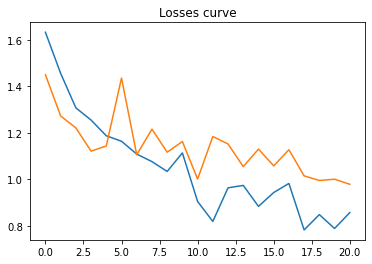

In [19]:
plt.figure()
plt.title('Losses curve')
plt.plot(np.arange(idx), train_losses[:idx])
plt.plot(np.arange(idx), val_losses[:idx])
plt.show()

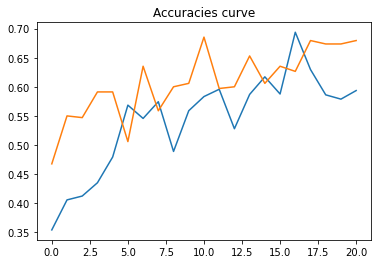

In [20]:
plt.figure()
plt.title('Accuracies curve')
plt.plot(np.arange(idx), train_accs[:idx])
plt.plot(np.arange(idx), val_accs[:idx])
plt.show()

In [21]:
submission = pd.read_csv('test_answer_sample_.csv', index_col=0)
preds_1 = np.load(f'1_preds.npy')
# preds_label_0 = [classes[p] for p in preds_0]
submission['answer value'] = preds_1
submission.to_csv(f'1_submission.csv')

In [22]:
# try 0 : baseline
# try 1 : horizontal flip 추가